## CatBoost
+ [CatBooost documentation](https://catboost.ai/docs/concepts/python-quickstart.html)
+ [data from](https://www.kaggle.com/c/avito-demand-prediction/data)

In [1]:
import numpy as np 
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

### Pre-processing

In [2]:
df = pd.read_csv('e:/data/train.csv', parse_dates = ['activation_date'])
df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.price.describe()

count       1418062.00
mean         316708.09
std        66891542.10
min               0.00
25%             500.00
50%            1300.00
75%            7000.00
max     79501011850.00
Name: price, dtype: float64

<Figure size 720x288 with 0 Axes>

Text(0.5,0,'Deal probability')

(0, 1)

Text(0.5,1,'Histogram of deal probability')

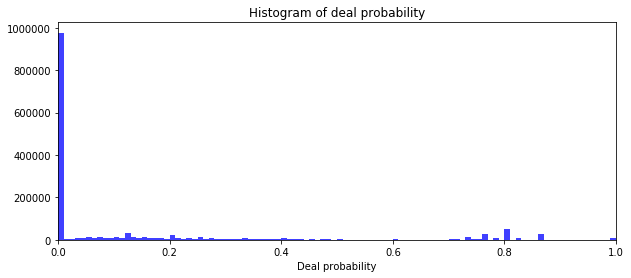

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)
plt.figure(figsize = (10, 4))
n, bins, patches = plt.hist(df['deal_probability'], 100, facecolor='blue', alpha=0.75)
plt.xlabel('Deal probability')
plt.xlim(0, 1)
plt.title('Histogram of deal probability')

<Figure size 720x288 with 0 Axes>

Text(0.5,0,'index')

Text(0,0.5,'deal probability')

Text(0.5,1,'Deal Probability Distribution')

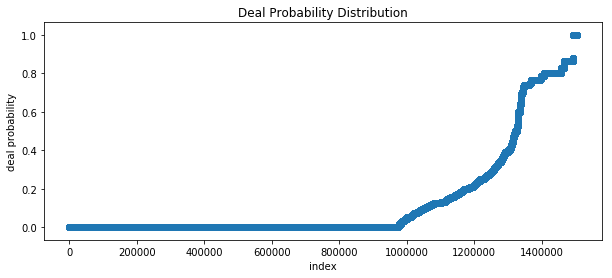

In [5]:
plt.figure(figsize = (10, 4))
plt.scatter(range(df.shape[0]), np.sort(df['deal_probability'].values))
plt.xlabel('index')
plt.ylabel('deal probability')
plt.title("Deal Probability Distribution")

Almost one million Ads has 0 probaility, which means it did not sell anything, and few ads have a probability of 1 which means it did sell something. The other ads have a probability in between 0 and 1. 

### Feature engineering

In [6]:
null_value_stats = df.isnull().sum()
null_value_stats
null_value_stats[null_value_stats != 0]

item_id                      0
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
param_1                  61576
param_2                 654542
param_3                 862565
title                        0
description             116276
price                    85362
item_seq_number              0
activation_date              0
user_type                    0
image                   112588
image_top_1             112588
deal_probability             0
dtype: int64

param_1         61576
param_2        654542
param_3        862565
description    116276
price           85362
image          112588
image_top_1    112588
dtype: int64

Fill missing features with -999, by filling missing values out of their distributions, the model would be able to easily distinguish between them and take it into account.

In [7]:
df.fillna(-999, inplace=True)

Create date time features.

In [8]:
df['year'] = df['activation_date'].dt.year
df['day_of_year'] = df['activation_date'].dt.dayofyear
df['weekday'] = df['activation_date'].dt.weekday
df['week_of_year'] = df['activation_date'].dt.week
df['day_of_month'] = df['activation_date'].dt.day
df['quarter'] = df['activation_date'].dt.quarter

df.drop('activation_date', axis=1, inplace=True)

In [9]:
df[:5]

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,user_type,image,image_top_1,deal_probability,year,day_of_year,weekday,week_of_year,day_of_month,quarter
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,-999,-999,Кокоби(кокон для сна),...,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.00,0.13,2017,87,1,13,28,1
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,-999,-999,Стойка для Одежды,...,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.00,0.00,2017,85,6,12,26,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",-999,-999,Philips bluray,...,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.00,0.43,2017,79,0,12,20,1
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,-999,-999,Автокресло,...,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.00,0.80,2017,84,5,12,25,1
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.00,0.21,2017,75,3,11,16,1


In [10]:
df.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'user_type', 'image',
       'image_top_1', 'deal_probability', 'year', 'day_of_year', 'weekday',
       'week_of_year', 'day_of_month', 'quarter'],
      dtype='object')

our features are of differnt types - some of them are numeric, some are categorical, and some are text such as title and description, and we could treat these text features just as categorical features.

In [11]:
categorical = ['item_id', 'user_id', 'region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'title', 'description', 'item_seq_number', 'user_type', 'image', 'image_top_1']

In [12]:
lbl = preprocessing.LabelEncoder()
for col in categorical: 
    df[col] = lbl.fit_transform(df[col].astype(str))

In [13]:
df.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,user_type,image,image_top_1,deal_probability,year,day_of_year,weekday,week_of_year,day_of_month,quarter
0,1087111,675853,19,460,4,42,249,0,0,298998,...,1,1135701,13,0.13,2017,87,1,13,28,1
1,267623,173962,17,1300,2,22,122,0,0,676606,...,1,661422,2722,0.00,2017,85,6,12,26,1
2,1095557,440069,16,1276,0,2,84,0,0,79843,...,1,999242,2260,0.43,2017,79,0,12,20,1


In [14]:
X = df.drop('deal_probability', axis=1)
y = df.deal_probability

In [15]:
# Prepare Categorical features indices
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]


categorical_features_indices = column_index(X, categorical)

In [16]:
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15],
      dtype=int64)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [18]:
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_valid, y_valid),plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2858390	test: 0.2853596	best: 0.2853596 (0)	total: 1.3s	remaining: 1m 3s
1:	learn: 0.2780301	test: 0.2775092	best: 0.2775092 (1)	total: 2.02s	remaining: 48.4s
2:	learn: 0.2713589	test: 0.2708617	best: 0.2708617 (2)	total: 2.73s	remaining: 42.8s
3:	learn: 0.2658761	test: 0.2653592	best: 0.2653592 (3)	total: 3.93s	remaining: 45.2s
4:	learn: 0.2612177	test: 0.2606641	best: 0.2606641 (4)	total: 5.01s	remaining: 45.1s
5:	learn: 0.2573610	test: 0.2568001	best: 0.2568001 (5)	total: 6.31s	remaining: 46.3s
6:	learn: 0.2541177	test: 0.2535532	best: 0.2535532 (6)	total: 6.94s	remaining: 42.7s
7:	learn: 0.2514324	test: 0.2508697	best: 0.2508697 (7)	total: 7.25s	remaining: 38.1s
8:	learn: 0.2490465	test: 0.2484551	best: 0.2484551 (8)	total: 7.95s	remaining: 36.2s
9:	learn: 0.2471560	test: 0.2465605	best: 0.2465605 (9)	total: 8.53s	remaining: 34.1s
10:	learn: 0.2455887	test: 0.2449559	best: 0.2449559 (10)	total: 8.82s	remaining: 31.3s
11:	learn: 0.2442686	test: 0.2436325	best: 0.2436325 

In [19]:
# df['price'] = np.log(df['price'] + 0.001)

### CatBoost model training

* Iterations is maximum number of trees that can be built when solving machine learning problems.

* learning_rate is used for reducing the gradient step.

* Depth is the depth of the tree. Any integer up to  16 when using CPU. 

* We calculate RMSE as metric.

* bagging_temperature defines the settings of the Bayesian bootstrap, the higher the value the more aggressive the bagging is. We do not want it high.

* We will use the overfitting detector, so, if overfitting occurs, CatBoost can stop the training earlier than the training parameters dictate. And the type of the overfitting detector is "Iter". 

* metric_period is the frequency of iterations to calculate the values of objectives and metrics.

* od_wait, Consider the model overfitted and stop training after the specified number of iterations (100) since the iteration with the optimal metric value.

* eval_set is the validation dataset for overfitting detector, best iteration selection and monitoring metrics' changes.

* use_bset_model = True if a validation set is input (the eval_set parameter is defined) and at least one of the label values of objects in this set differs from the others.

In [20]:
# model =  CatBoostRegressor(iterations=700,
#                              learning_rate=0.01,
#                              depth=16,
#                              eval_metric='RMSE',
#                              random_seed = 42,
#                              bagging_temperature = 0.2,
#                              od_type='Iter',
#                              metric_period = 75,
#                              od_wait=100)
# model.fit(X_train, y_train,
#                  eval_set=(X_valid, y_valid),
#                  cat_features=categorical_features_indices,
#                  use_best_model=True)

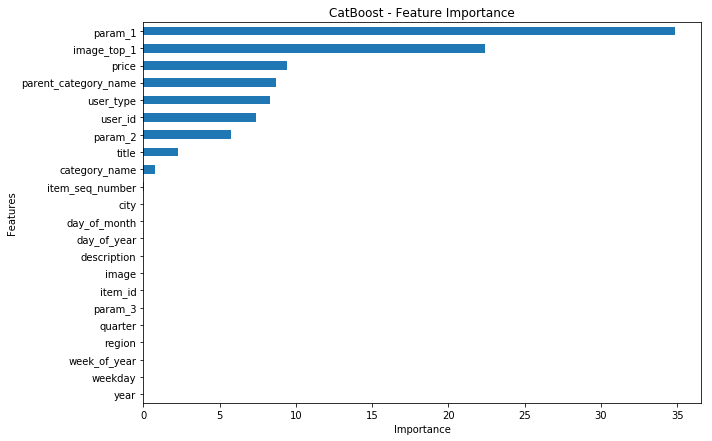

In [21]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [22]:
fea_imp

,col,imp
16,year,0.00
18,weekday,0.00
19,week_of_year,0.00
2,region,0.00
21,quarter,0.00
8,param_3,0.00
0,item_id,0.00
14,image,0.00
10,description,0.00
17,day_of_year,0.00


In [23]:
# model evaluation
from sklearn.metrics import mean_squared_error
print('Model evaluation:')
print(model.get_params())
print('RMSE:', np.sqrt(mean_squared_error(y_valid, model.predict(X_valid))))

Model evaluation:
{'loss_function': 'RMSE', 'depth': 3, 'learning_rate': 0.1, 'iterations': 50}
RMSE: 0.23159533579742986


## LightGBM
+ [LightGBM](http://lightgbm.apachecn.org/#/)
+ [参考](https://blog.csdn.net/weixin_39807102/article/details/81912566)

In [25]:
import time
import gc
import random
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [27]:
import lightgbm as lgb

df = pd.read_csv('e:/data/train.csv', parse_dates = ['activation_date'])
df['year'] = df['activation_date'].dt.year
df['day_of_year'] = df['activation_date'].dt.dayofyear
df['weekday'] = df['activation_date'].dt.weekday
df['week_of_year'] = df['activation_date'].dt.week
df['day_of_month'] = df['activation_date'].dt.day
df['quarter'] = df['activation_date'].dt.quarter

df.drop('activation_date', axis=1, inplace=True)

In [28]:
df.drop('image', axis=1, inplace=True)

In [29]:
y = df['deal_probability'].values

In [30]:
df.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,item_seq_number,user_type,image_top_1,deal_probability,year,day_of_year,weekday,week_of_year,day_of_month,quarter
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2,Private,1008.00,0.13,2017,87,1,13,28,1
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,19,Private,692.00,0.00,2017,85,6,12,26,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,9,Private,3032.00,0.43,2017,79,0,12,20,1


In [34]:
categorical = ["user_id", "region","city", "parent_category_name", "category_name", "user_type", "image_top_1", "param_1", "param_2", "param_3"]
# Fill NA values for image_top_1 with -1
df["image_top_1"].fillna(-1, inplace=True)

label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna("unknown",inplace=True)
    df[col] = label_encoder.fit_transform(df[col].astype(str))

In [35]:
df["price"].fillna(df.price.median(), inplace=True)
df["price"] = np.log1p(df["price"])

In [36]:
df.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'user_type', 'image_top_1',
       'deal_probability', 'year', 'day_of_year', 'weekday', 'week_of_year',
       'day_of_month', 'quarter'],
      dtype='object')

In [37]:
df.drop(['item_id', 'title', 'description'], axis=1, inplace=True)
X = df.loc[:, df.columns != 'deal_probability']

In [39]:
feature_names = X.columns.tolist()
feature_names
print("Number of featues: ", len(feature_names))

['user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'price',
 'item_seq_number',
 'user_type',
 'image_top_1',
 'year',
 'day_of_year',
 'weekday',
 'week_of_year',
 'day_of_month',
 'quarter']

Number of featues:  18


### lightGBM model training

In [40]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)
    
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=feature_names,
                categorical_feature = categorical)
# del X, X_train
gc.collect()

2843

In [47]:
lgb_clf = lgb.train(
    params,
    lgtrain,
    num_boost_round=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=500
)
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_valid, lgb_clf.predict(X_valid))))

D:\ProgramData\Anaconda3\envs\normal\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\ProgramData\Anaconda3\envs\normal\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's rmse: 0.259652	valid's rmse: 0.259236
Training until validation scores don't improve for 500 rounds.
[2]	train's rmse: 0.2591	valid's rmse: 0.2587
[3]	train's rmse: 0.258566	valid's rmse: 0.25818
[4]	train's rmse: 0.258056	valid's rmse: 0.257683
[5]	train's rmse: 0.257538	valid's rmse: 0.257178
[6]	train's rmse: 0.257042	valid's rmse: 0.2567
[7]	train's rmse: 0.256536	valid's rmse: 0.256214
[8]	train's rmse: 0.256048	valid's rmse: 0.255745
[9]	train's rmse: 0.255605	valid's rmse: 0.255313
[10]	train's rmse: 0.25512	valid's rmse: 0.254842
[11]	train's rmse: 0.254721	valid's rmse: 0.254449
[12]	train's rmse: 0.254264	valid's rmse: 0.254011
[13]	train's rmse: 0.253816	valid's rmse: 0.253582
[14]	train's rmse: 0.253352	valid's rmse: 0.253131
[15]	train's rmse: 0.252929	valid's rmse: 0.252719
[16]	train's rmse: 0.252499	valid's rmse: 0.252304
[17]	train's rmse: 0.2521	valid's rmse: 0.251916
[18]	train's rmse: 0.251691	valid's rmse: 0.251521
[19]	train's rmse: 0.251297	valid's rm

[162]	train's rmse: 0.227583	valid's rmse: 0.229254
[163]	train's rmse: 0.2275	valid's rmse: 0.229191
[164]	train's rmse: 0.227418	valid's rmse: 0.229127
[165]	train's rmse: 0.227336	valid's rmse: 0.229063
[166]	train's rmse: 0.227257	valid's rmse: 0.228998
[167]	train's rmse: 0.227215	valid's rmse: 0.228962
[168]	train's rmse: 0.227152	valid's rmse: 0.228918
[169]	train's rmse: 0.227113	valid's rmse: 0.228885
[170]	train's rmse: 0.227056	valid's rmse: 0.228844
[171]	train's rmse: 0.227001	valid's rmse: 0.228794
[172]	train's rmse: 0.226923	valid's rmse: 0.228736
[173]	train's rmse: 0.226854	valid's rmse: 0.228684
[174]	train's rmse: 0.226805	valid's rmse: 0.228648
[175]	train's rmse: 0.226751	valid's rmse: 0.228611
[176]	train's rmse: 0.226701	valid's rmse: 0.228565
[177]	train's rmse: 0.226626	valid's rmse: 0.22851
[178]	train's rmse: 0.226576	valid's rmse: 0.228472
[179]	train's rmse: 0.226509	valid's rmse: 0.228423
[180]	train's rmse: 0.226455	valid's rmse: 0.228386
[181]	train's r

[323]	train's rmse: 0.221863	valid's rmse: 0.225436
[324]	train's rmse: 0.221839	valid's rmse: 0.225424
[325]	train's rmse: 0.221827	valid's rmse: 0.225418
[326]	train's rmse: 0.221801	valid's rmse: 0.2254
[327]	train's rmse: 0.221776	valid's rmse: 0.225384
[328]	train's rmse: 0.221764	valid's rmse: 0.225379
[329]	train's rmse: 0.221749	valid's rmse: 0.225369
[330]	train's rmse: 0.221727	valid's rmse: 0.225356
[331]	train's rmse: 0.221703	valid's rmse: 0.225345
[332]	train's rmse: 0.221684	valid's rmse: 0.225338
[333]	train's rmse: 0.221659	valid's rmse: 0.225325
[334]	train's rmse: 0.221639	valid's rmse: 0.225316
[335]	train's rmse: 0.221626	valid's rmse: 0.225311
[336]	train's rmse: 0.221609	valid's rmse: 0.2253
[337]	train's rmse: 0.221585	valid's rmse: 0.225285
[338]	train's rmse: 0.221571	valid's rmse: 0.225279
[339]	train's rmse: 0.221547	valid's rmse: 0.225268
[340]	train's rmse: 0.221534	valid's rmse: 0.225262
[341]	train's rmse: 0.221516	valid's rmse: 0.225255
[342]	train's rm

[485]	train's rmse: 0.219633	valid's rmse: 0.224479
[486]	train's rmse: 0.219623	valid's rmse: 0.224478
[487]	train's rmse: 0.219605	valid's rmse: 0.22447
[488]	train's rmse: 0.219587	valid's rmse: 0.224462
[489]	train's rmse: 0.219568	valid's rmse: 0.224453
[490]	train's rmse: 0.219551	valid's rmse: 0.224446
[491]	train's rmse: 0.219538	valid's rmse: 0.224438
[492]	train's rmse: 0.219521	valid's rmse: 0.22443
[493]	train's rmse: 0.219506	valid's rmse: 0.224422
[494]	train's rmse: 0.219501	valid's rmse: 0.22442
[495]	train's rmse: 0.219498	valid's rmse: 0.224419
[496]	train's rmse: 0.219484	valid's rmse: 0.224408
[497]	train's rmse: 0.219474	valid's rmse: 0.224406
[498]	train's rmse: 0.219463	valid's rmse: 0.224405
[499]	train's rmse: 0.219444	valid's rmse: 0.224397
[500]	train's rmse: 0.219437	valid's rmse: 0.224395
[501]	train's rmse: 0.219432	valid's rmse: 0.224394
[502]	train's rmse: 0.219425	valid's rmse: 0.224393
[503]	train's rmse: 0.219407	valid's rmse: 0.224385
[504]	train's r

[647]	train's rmse: 0.218082	valid's rmse: 0.223979
[648]	train's rmse: 0.218073	valid's rmse: 0.223975
[649]	train's rmse: 0.218067	valid's rmse: 0.223974
[650]	train's rmse: 0.218064	valid's rmse: 0.223973
[651]	train's rmse: 0.218061	valid's rmse: 0.223973
[652]	train's rmse: 0.218054	valid's rmse: 0.223972
[653]	train's rmse: 0.218048	valid's rmse: 0.223971
[654]	train's rmse: 0.218044	valid's rmse: 0.22397
[655]	train's rmse: 0.218034	valid's rmse: 0.223968
[656]	train's rmse: 0.218029	valid's rmse: 0.223966
[657]	train's rmse: 0.218023	valid's rmse: 0.223964
[658]	train's rmse: 0.218015	valid's rmse: 0.223963
[659]	train's rmse: 0.218	valid's rmse: 0.223959
[660]	train's rmse: 0.217992	valid's rmse: 0.223957
[661]	train's rmse: 0.217989	valid's rmse: 0.223956
[662]	train's rmse: 0.217986	valid's rmse: 0.223956
[663]	train's rmse: 0.217983	valid's rmse: 0.223955
[664]	train's rmse: 0.217975	valid's rmse: 0.223952
[665]	train's rmse: 0.217968	valid's rmse: 0.22395
[666]	train's rms

[806]	train's rmse: 0.217144	valid's rmse: 0.223752
[807]	train's rmse: 0.217137	valid's rmse: 0.223751
[808]	train's rmse: 0.21713	valid's rmse: 0.223749
[809]	train's rmse: 0.217125	valid's rmse: 0.223749
[810]	train's rmse: 0.21712	valid's rmse: 0.223749
[811]	train's rmse: 0.217114	valid's rmse: 0.223749
[812]	train's rmse: 0.217113	valid's rmse: 0.223748
[813]	train's rmse: 0.217109	valid's rmse: 0.223747
[814]	train's rmse: 0.2171	valid's rmse: 0.223747
[815]	train's rmse: 0.217087	valid's rmse: 0.223744
[816]	train's rmse: 0.217081	valid's rmse: 0.223743
[817]	train's rmse: 0.217073	valid's rmse: 0.223742
[818]	train's rmse: 0.217065	valid's rmse: 0.223741
[819]	train's rmse: 0.217061	valid's rmse: 0.223741
[820]	train's rmse: 0.217059	valid's rmse: 0.223741
[821]	train's rmse: 0.217052	valid's rmse: 0.22374
[822]	train's rmse: 0.217052	valid's rmse: 0.22374
[823]	train's rmse: 0.217044	valid's rmse: 0.223737
[824]	train's rmse: 0.217036	valid's rmse: 0.223735
[825]	train's rmse

[966]	train's rmse: 0.216261	valid's rmse: 0.223584
[967]	train's rmse: 0.216254	valid's rmse: 0.223583
[968]	train's rmse: 0.216251	valid's rmse: 0.223583
[969]	train's rmse: 0.216249	valid's rmse: 0.223583
[970]	train's rmse: 0.216241	valid's rmse: 0.223582
[971]	train's rmse: 0.216234	valid's rmse: 0.223582
[972]	train's rmse: 0.216222	valid's rmse: 0.223579
[973]	train's rmse: 0.216218	valid's rmse: 0.223579
[974]	train's rmse: 0.216208	valid's rmse: 0.223576
[975]	train's rmse: 0.2162	valid's rmse: 0.223575
[976]	train's rmse: 0.21619	valid's rmse: 0.223572
[977]	train's rmse: 0.216183	valid's rmse: 0.223571
[978]	train's rmse: 0.216181	valid's rmse: 0.223571
[979]	train's rmse: 0.216179	valid's rmse: 0.22357
[980]	train's rmse: 0.216172	valid's rmse: 0.223569
[981]	train's rmse: 0.216166	valid's rmse: 0.223568
[982]	train's rmse: 0.216166	valid's rmse: 0.223568
[983]	train's rmse: 0.216165	valid's rmse: 0.223568
[984]	train's rmse: 0.216155	valid's rmse: 0.223564
[985]	train's rm

[1123]	train's rmse: 0.215524	valid's rmse: 0.223458
[1124]	train's rmse: 0.215519	valid's rmse: 0.223458
[1125]	train's rmse: 0.215516	valid's rmse: 0.223457
[1126]	train's rmse: 0.215511	valid's rmse: 0.223456
[1127]	train's rmse: 0.215508	valid's rmse: 0.223455
[1128]	train's rmse: 0.215499	valid's rmse: 0.223455
[1129]	train's rmse: 0.215492	valid's rmse: 0.223455
[1130]	train's rmse: 0.215486	valid's rmse: 0.223453
[1131]	train's rmse: 0.21548	valid's rmse: 0.223453
[1132]	train's rmse: 0.215473	valid's rmse: 0.223452
[1133]	train's rmse: 0.215469	valid's rmse: 0.223452
[1134]	train's rmse: 0.215463	valid's rmse: 0.223451
[1135]	train's rmse: 0.215455	valid's rmse: 0.223451
[1136]	train's rmse: 0.215455	valid's rmse: 0.223451
[1137]	train's rmse: 0.215453	valid's rmse: 0.22345
[1138]	train's rmse: 0.215442	valid's rmse: 0.223448
[1139]	train's rmse: 0.215436	valid's rmse: 0.223447
[1140]	train's rmse: 0.215429	valid's rmse: 0.223446
[1141]	train's rmse: 0.215427	valid's rmse: 0.22

[1281]	train's rmse: 0.214844	valid's rmse: 0.223366
[1282]	train's rmse: 0.21484	valid's rmse: 0.223366
[1283]	train's rmse: 0.214839	valid's rmse: 0.223366
[1284]	train's rmse: 0.214834	valid's rmse: 0.223365
[1285]	train's rmse: 0.214834	valid's rmse: 0.223365
[1286]	train's rmse: 0.214826	valid's rmse: 0.223365
[1287]	train's rmse: 0.214823	valid's rmse: 0.223365
[1288]	train's rmse: 0.214815	valid's rmse: 0.223364
[1289]	train's rmse: 0.214808	valid's rmse: 0.223362
[1290]	train's rmse: 0.214808	valid's rmse: 0.223362
[1291]	train's rmse: 0.2148	valid's rmse: 0.223362
[1292]	train's rmse: 0.214794	valid's rmse: 0.223362
[1293]	train's rmse: 0.214786	valid's rmse: 0.22336
[1294]	train's rmse: 0.21478	valid's rmse: 0.22336
[1295]	train's rmse: 0.214774	valid's rmse: 0.223359
[1296]	train's rmse: 0.214773	valid's rmse: 0.223358
[1297]	train's rmse: 0.214772	valid's rmse: 0.223358
[1298]	train's rmse: 0.214764	valid's rmse: 0.223357
[1299]	train's rmse: 0.214758	valid's rmse: 0.223357

[1437]	train's rmse: 0.214118	valid's rmse: 0.223261
[1438]	train's rmse: 0.214112	valid's rmse: 0.22326
[1439]	train's rmse: 0.214106	valid's rmse: 0.22326
[1440]	train's rmse: 0.214102	valid's rmse: 0.223259
[1441]	train's rmse: 0.214096	valid's rmse: 0.223259
[1442]	train's rmse: 0.214094	valid's rmse: 0.223259
[1443]	train's rmse: 0.214091	valid's rmse: 0.223259
[1444]	train's rmse: 0.214085	valid's rmse: 0.223258
[1445]	train's rmse: 0.21408	valid's rmse: 0.223259
[1446]	train's rmse: 0.214077	valid's rmse: 0.223258
[1447]	train's rmse: 0.214071	valid's rmse: 0.223258
[1448]	train's rmse: 0.214065	valid's rmse: 0.223258
[1449]	train's rmse: 0.214059	valid's rmse: 0.223258
[1450]	train's rmse: 0.214052	valid's rmse: 0.223258
[1451]	train's rmse: 0.214046	valid's rmse: 0.223258
[1452]	train's rmse: 0.214041	valid's rmse: 0.223257
[1453]	train's rmse: 0.214041	valid's rmse: 0.223257
[1454]	train's rmse: 0.214037	valid's rmse: 0.223256
[1455]	train's rmse: 0.214033	valid's rmse: 0.223

[1595]	train's rmse: 0.21344	valid's rmse: 0.223186
[1596]	train's rmse: 0.213437	valid's rmse: 0.223187
[1597]	train's rmse: 0.21343	valid's rmse: 0.223186
[1598]	train's rmse: 0.21343	valid's rmse: 0.223186
[1599]	train's rmse: 0.213428	valid's rmse: 0.223185
[1600]	train's rmse: 0.213422	valid's rmse: 0.223184
[1601]	train's rmse: 0.213419	valid's rmse: 0.223184
[1602]	train's rmse: 0.213417	valid's rmse: 0.223184
[1603]	train's rmse: 0.213416	valid's rmse: 0.223184
[1604]	train's rmse: 0.213413	valid's rmse: 0.223184
[1605]	train's rmse: 0.213406	valid's rmse: 0.223183
[1606]	train's rmse: 0.213403	valid's rmse: 0.223181
[1607]	train's rmse: 0.213398	valid's rmse: 0.22318
[1608]	train's rmse: 0.213391	valid's rmse: 0.223179
[1609]	train's rmse: 0.213383	valid's rmse: 0.223179
[1610]	train's rmse: 0.213382	valid's rmse: 0.223179
[1611]	train's rmse: 0.213376	valid's rmse: 0.223178
[1612]	train's rmse: 0.213373	valid's rmse: 0.223178
[1613]	train's rmse: 0.213372	valid's rmse: 0.2231

[1754]	train's rmse: 0.212836	valid's rmse: 0.223126
[1755]	train's rmse: 0.212833	valid's rmse: 0.223126
[1756]	train's rmse: 0.212831	valid's rmse: 0.223126
[1757]	train's rmse: 0.212826	valid's rmse: 0.223127
[1758]	train's rmse: 0.212822	valid's rmse: 0.223126
[1759]	train's rmse: 0.212821	valid's rmse: 0.223126
[1760]	train's rmse: 0.212818	valid's rmse: 0.223126
[1761]	train's rmse: 0.212815	valid's rmse: 0.223125
[1762]	train's rmse: 0.21281	valid's rmse: 0.223125
[1763]	train's rmse: 0.212804	valid's rmse: 0.223124
[1764]	train's rmse: 0.212797	valid's rmse: 0.223123
[1765]	train's rmse: 0.212791	valid's rmse: 0.223123
[1766]	train's rmse: 0.212786	valid's rmse: 0.223122
[1767]	train's rmse: 0.212781	valid's rmse: 0.223121
[1768]	train's rmse: 0.212774	valid's rmse: 0.22312
[1769]	train's rmse: 0.212769	valid's rmse: 0.22312
[1770]	train's rmse: 0.212765	valid's rmse: 0.223119
[1771]	train's rmse: 0.212761	valid's rmse: 0.223119
[1772]	train's rmse: 0.212759	valid's rmse: 0.223

[1910]	train's rmse: 0.212157	valid's rmse: 0.223068
[1911]	train's rmse: 0.212152	valid's rmse: 0.223068
[1912]	train's rmse: 0.212144	valid's rmse: 0.223067
[1913]	train's rmse: 0.212139	valid's rmse: 0.223067
[1914]	train's rmse: 0.212138	valid's rmse: 0.223067
[1915]	train's rmse: 0.212134	valid's rmse: 0.223066
[1916]	train's rmse: 0.212129	valid's rmse: 0.223066
[1917]	train's rmse: 0.212126	valid's rmse: 0.223066
[1918]	train's rmse: 0.212122	valid's rmse: 0.223065
[1919]	train's rmse: 0.212117	valid's rmse: 0.223064
[1920]	train's rmse: 0.212112	valid's rmse: 0.223064
[1921]	train's rmse: 0.212105	valid's rmse: 0.223063
[1922]	train's rmse: 0.212102	valid's rmse: 0.223062
[1923]	train's rmse: 0.212097	valid's rmse: 0.223063
[1924]	train's rmse: 0.212097	valid's rmse: 0.223063
[1925]	train's rmse: 0.21209	valid's rmse: 0.223062
[1926]	train's rmse: 0.212086	valid's rmse: 0.223062
[1927]	train's rmse: 0.212082	valid's rmse: 0.223061
[1928]	train's rmse: 0.212077	valid's rmse: 0.2

[2067]	train's rmse: 0.211475	valid's rmse: 0.223016
[2068]	train's rmse: 0.211469	valid's rmse: 0.223016
[2069]	train's rmse: 0.211462	valid's rmse: 0.223015
[2070]	train's rmse: 0.211457	valid's rmse: 0.223015
[2071]	train's rmse: 0.211456	valid's rmse: 0.223015
[2072]	train's rmse: 0.211451	valid's rmse: 0.223014
[2073]	train's rmse: 0.211447	valid's rmse: 0.223013
[2074]	train's rmse: 0.211441	valid's rmse: 0.223013
[2075]	train's rmse: 0.211438	valid's rmse: 0.223013
[2076]	train's rmse: 0.211435	valid's rmse: 0.223013
[2077]	train's rmse: 0.211434	valid's rmse: 0.223012
[2078]	train's rmse: 0.211433	valid's rmse: 0.223012
[2079]	train's rmse: 0.21143	valid's rmse: 0.223012
[2080]	train's rmse: 0.211425	valid's rmse: 0.223013
[2081]	train's rmse: 0.21142	valid's rmse: 0.223012
[2082]	train's rmse: 0.211419	valid's rmse: 0.223012
[2083]	train's rmse: 0.211415	valid's rmse: 0.223012
[2084]	train's rmse: 0.211412	valid's rmse: 0.223012
[2085]	train's rmse: 0.211412	valid's rmse: 0.22

[2226]	train's rmse: 0.210861	valid's rmse: 0.222978
[2227]	train's rmse: 0.210857	valid's rmse: 0.222978
[2228]	train's rmse: 0.210853	valid's rmse: 0.222978
[2229]	train's rmse: 0.210853	valid's rmse: 0.222977
[2230]	train's rmse: 0.210849	valid's rmse: 0.222977
[2231]	train's rmse: 0.210847	valid's rmse: 0.222977
[2232]	train's rmse: 0.210843	valid's rmse: 0.222978
[2233]	train's rmse: 0.210836	valid's rmse: 0.222977
[2234]	train's rmse: 0.210832	valid's rmse: 0.222977
[2235]	train's rmse: 0.210827	valid's rmse: 0.222976
[2236]	train's rmse: 0.210824	valid's rmse: 0.222975
[2237]	train's rmse: 0.21082	valid's rmse: 0.222975
[2238]	train's rmse: 0.210816	valid's rmse: 0.222975
[2239]	train's rmse: 0.210815	valid's rmse: 0.222975
[2240]	train's rmse: 0.21081	valid's rmse: 0.222975
[2241]	train's rmse: 0.210805	valid's rmse: 0.222975
[2242]	train's rmse: 0.2108	valid's rmse: 0.222975
[2243]	train's rmse: 0.210797	valid's rmse: 0.222974
[2244]	train's rmse: 0.210792	valid's rmse: 0.2229

[2384]	train's rmse: 0.210296	valid's rmse: 0.222951
[2385]	train's rmse: 0.210291	valid's rmse: 0.222951
[2386]	train's rmse: 0.210289	valid's rmse: 0.222951
[2387]	train's rmse: 0.210284	valid's rmse: 0.222951
[2388]	train's rmse: 0.210281	valid's rmse: 0.222951
[2389]	train's rmse: 0.210277	valid's rmse: 0.222951
[2390]	train's rmse: 0.210274	valid's rmse: 0.222951
[2391]	train's rmse: 0.210272	valid's rmse: 0.222951
[2392]	train's rmse: 0.210266	valid's rmse: 0.222951
[2393]	train's rmse: 0.210264	valid's rmse: 0.222951
[2394]	train's rmse: 0.210261	valid's rmse: 0.222952
[2395]	train's rmse: 0.210255	valid's rmse: 0.222951
[2396]	train's rmse: 0.210253	valid's rmse: 0.222952
[2397]	train's rmse: 0.210249	valid's rmse: 0.222952
[2398]	train's rmse: 0.210245	valid's rmse: 0.222952
[2399]	train's rmse: 0.21024	valid's rmse: 0.222952
[2400]	train's rmse: 0.210236	valid's rmse: 0.222952
[2401]	train's rmse: 0.210232	valid's rmse: 0.222951
[2402]	train's rmse: 0.210228	valid's rmse: 0.2

[2543]	train's rmse: 0.209705	valid's rmse: 0.222928
[2544]	train's rmse: 0.209703	valid's rmse: 0.222927
[2545]	train's rmse: 0.209703	valid's rmse: 0.222927
[2546]	train's rmse: 0.2097	valid's rmse: 0.222927
[2547]	train's rmse: 0.209697	valid's rmse: 0.222927
[2548]	train's rmse: 0.209695	valid's rmse: 0.222927
[2549]	train's rmse: 0.20969	valid's rmse: 0.222927
[2550]	train's rmse: 0.209687	valid's rmse: 0.222927
[2551]	train's rmse: 0.209681	valid's rmse: 0.222926
[2552]	train's rmse: 0.209675	valid's rmse: 0.222926
[2553]	train's rmse: 0.209674	valid's rmse: 0.222926
[2554]	train's rmse: 0.20967	valid's rmse: 0.222926
[2555]	train's rmse: 0.209665	valid's rmse: 0.222926
[2556]	train's rmse: 0.209661	valid's rmse: 0.222925
[2557]	train's rmse: 0.209658	valid's rmse: 0.222925
[2558]	train's rmse: 0.209654	valid's rmse: 0.222924
[2559]	train's rmse: 0.20965	valid's rmse: 0.222924
[2560]	train's rmse: 0.209647	valid's rmse: 0.222925
[2561]	train's rmse: 0.209641	valid's rmse: 0.22292

[2699]	train's rmse: 0.209173	valid's rmse: 0.222902
[2700]	train's rmse: 0.209168	valid's rmse: 0.222902
[2701]	train's rmse: 0.209166	valid's rmse: 0.222902
[2702]	train's rmse: 0.209162	valid's rmse: 0.222902
[2703]	train's rmse: 0.209157	valid's rmse: 0.222902
[2704]	train's rmse: 0.209151	valid's rmse: 0.222902
[2705]	train's rmse: 0.209146	valid's rmse: 0.222902
[2706]	train's rmse: 0.209144	valid's rmse: 0.222902
[2707]	train's rmse: 0.209141	valid's rmse: 0.222902
[2708]	train's rmse: 0.209138	valid's rmse: 0.222902
[2709]	train's rmse: 0.209135	valid's rmse: 0.222902
[2710]	train's rmse: 0.209133	valid's rmse: 0.222902
[2711]	train's rmse: 0.209127	valid's rmse: 0.222902
[2712]	train's rmse: 0.209124	valid's rmse: 0.222902
[2713]	train's rmse: 0.209122	valid's rmse: 0.222901
[2714]	train's rmse: 0.209116	valid's rmse: 0.222901
[2715]	train's rmse: 0.209114	valid's rmse: 0.222901
[2716]	train's rmse: 0.209111	valid's rmse: 0.222901
[2717]	train's rmse: 0.209109	valid's rmse: 0.

[2858]	train's rmse: 0.208618	valid's rmse: 0.222878
[2859]	train's rmse: 0.208616	valid's rmse: 0.222878
[2860]	train's rmse: 0.208613	valid's rmse: 0.222878
[2861]	train's rmse: 0.20861	valid's rmse: 0.222877
[2862]	train's rmse: 0.208605	valid's rmse: 0.222877
[2863]	train's rmse: 0.208603	valid's rmse: 0.222877
[2864]	train's rmse: 0.2086	valid's rmse: 0.222877
[2865]	train's rmse: 0.208596	valid's rmse: 0.222877
[2866]	train's rmse: 0.208592	valid's rmse: 0.222877
[2867]	train's rmse: 0.208591	valid's rmse: 0.222878
[2868]	train's rmse: 0.208589	valid's rmse: 0.222877
[2869]	train's rmse: 0.208585	valid's rmse: 0.222877
[2870]	train's rmse: 0.208581	valid's rmse: 0.222877
[2871]	train's rmse: 0.208578	valid's rmse: 0.222877
[2872]	train's rmse: 0.208574	valid's rmse: 0.222877
[2873]	train's rmse: 0.208572	valid's rmse: 0.222877
[2874]	train's rmse: 0.208568	valid's rmse: 0.222876
[2875]	train's rmse: 0.208565	valid's rmse: 0.222876
[2876]	train's rmse: 0.208562	valid's rmse: 0.222

[3014]	train's rmse: 0.20811	valid's rmse: 0.222861
[3015]	train's rmse: 0.208106	valid's rmse: 0.222861
[3016]	train's rmse: 0.208102	valid's rmse: 0.222861
[3017]	train's rmse: 0.208099	valid's rmse: 0.22286
[3018]	train's rmse: 0.208096	valid's rmse: 0.22286
[3019]	train's rmse: 0.208094	valid's rmse: 0.22286
[3020]	train's rmse: 0.208091	valid's rmse: 0.22286
[3021]	train's rmse: 0.208088	valid's rmse: 0.22286
[3022]	train's rmse: 0.208082	valid's rmse: 0.22286
[3023]	train's rmse: 0.208078	valid's rmse: 0.22286
[3024]	train's rmse: 0.208076	valid's rmse: 0.22286
[3025]	train's rmse: 0.208074	valid's rmse: 0.22286
[3026]	train's rmse: 0.208073	valid's rmse: 0.22286
[3027]	train's rmse: 0.208068	valid's rmse: 0.222859
[3028]	train's rmse: 0.208066	valid's rmse: 0.222859
[3029]	train's rmse: 0.208062	valid's rmse: 0.222859
[3030]	train's rmse: 0.208059	valid's rmse: 0.222858
[3031]	train's rmse: 0.208056	valid's rmse: 0.222858
[3032]	train's rmse: 0.208054	valid's rmse: 0.222858
[303

[3173]	train's rmse: 0.20757	valid's rmse: 0.222847
[3174]	train's rmse: 0.207566	valid's rmse: 0.222847
[3175]	train's rmse: 0.207562	valid's rmse: 0.222847
[3176]	train's rmse: 0.207559	valid's rmse: 0.222847
[3177]	train's rmse: 0.207556	valid's rmse: 0.222847
[3178]	train's rmse: 0.207553	valid's rmse: 0.222847
[3179]	train's rmse: 0.207549	valid's rmse: 0.222847
[3180]	train's rmse: 0.207547	valid's rmse: 0.222847
[3181]	train's rmse: 0.207545	valid's rmse: 0.222847
[3182]	train's rmse: 0.207542	valid's rmse: 0.222847
[3183]	train's rmse: 0.207537	valid's rmse: 0.222847
[3184]	train's rmse: 0.207532	valid's rmse: 0.222846
[3185]	train's rmse: 0.207527	valid's rmse: 0.222847
[3186]	train's rmse: 0.207524	valid's rmse: 0.222846
[3187]	train's rmse: 0.20752	valid's rmse: 0.222845
[3188]	train's rmse: 0.207517	valid's rmse: 0.222845
[3189]	train's rmse: 0.207514	valid's rmse: 0.222845
[3190]	train's rmse: 0.207512	valid's rmse: 0.222845
[3191]	train's rmse: 0.207509	valid's rmse: 0.22

[3331]	train's rmse: 0.207094	valid's rmse: 0.222829
[3332]	train's rmse: 0.207091	valid's rmse: 0.222829
[3333]	train's rmse: 0.207089	valid's rmse: 0.222829
[3334]	train's rmse: 0.207088	valid's rmse: 0.222829
[3335]	train's rmse: 0.207086	valid's rmse: 0.222829
[3336]	train's rmse: 0.207083	valid's rmse: 0.222829
[3337]	train's rmse: 0.20708	valid's rmse: 0.222829
[3338]	train's rmse: 0.207077	valid's rmse: 0.222829
[3339]	train's rmse: 0.207074	valid's rmse: 0.222829
[3340]	train's rmse: 0.207071	valid's rmse: 0.222829
[3341]	train's rmse: 0.207069	valid's rmse: 0.222829
[3342]	train's rmse: 0.207067	valid's rmse: 0.222829
[3343]	train's rmse: 0.207065	valid's rmse: 0.222829
[3344]	train's rmse: 0.207063	valid's rmse: 0.222829
[3345]	train's rmse: 0.207061	valid's rmse: 0.222829
[3346]	train's rmse: 0.207059	valid's rmse: 0.222829
[3347]	train's rmse: 0.207057	valid's rmse: 0.222829
[3348]	train's rmse: 0.207055	valid's rmse: 0.222829
[3349]	train's rmse: 0.207053	valid's rmse: 0.2

[3489]	train's rmse: 0.206638	valid's rmse: 0.22282
[3490]	train's rmse: 0.206635	valid's rmse: 0.22282
[3491]	train's rmse: 0.206632	valid's rmse: 0.222819
[3492]	train's rmse: 0.206629	valid's rmse: 0.222819
[3493]	train's rmse: 0.206627	valid's rmse: 0.222819
[3494]	train's rmse: 0.206625	valid's rmse: 0.222819
[3495]	train's rmse: 0.206623	valid's rmse: 0.222819
[3496]	train's rmse: 0.20662	valid's rmse: 0.222819
[3497]	train's rmse: 0.206618	valid's rmse: 0.222819
[3498]	train's rmse: 0.206616	valid's rmse: 0.222819
[3499]	train's rmse: 0.206612	valid's rmse: 0.222819
[3500]	train's rmse: 0.206609	valid's rmse: 0.222819
[3501]	train's rmse: 0.206607	valid's rmse: 0.222819
[3502]	train's rmse: 0.206604	valid's rmse: 0.222819
[3503]	train's rmse: 0.2066	valid's rmse: 0.222818
[3504]	train's rmse: 0.206599	valid's rmse: 0.222818
[3505]	train's rmse: 0.206597	valid's rmse: 0.222818
[3506]	train's rmse: 0.206595	valid's rmse: 0.222818
[3507]	train's rmse: 0.206592	valid's rmse: 0.22281

[3645]	train's rmse: 0.206208	valid's rmse: 0.222811
[3646]	train's rmse: 0.206203	valid's rmse: 0.222811
[3647]	train's rmse: 0.206201	valid's rmse: 0.222811
[3648]	train's rmse: 0.206199	valid's rmse: 0.222811
[3649]	train's rmse: 0.206195	valid's rmse: 0.222811
[3650]	train's rmse: 0.206192	valid's rmse: 0.22281
[3651]	train's rmse: 0.20619	valid's rmse: 0.22281
[3652]	train's rmse: 0.206187	valid's rmse: 0.22281
[3653]	train's rmse: 0.206183	valid's rmse: 0.222809
[3654]	train's rmse: 0.206181	valid's rmse: 0.222809
[3655]	train's rmse: 0.206178	valid's rmse: 0.222809
[3656]	train's rmse: 0.206176	valid's rmse: 0.222809
[3657]	train's rmse: 0.206174	valid's rmse: 0.222809
[3658]	train's rmse: 0.206172	valid's rmse: 0.222809
[3659]	train's rmse: 0.20617	valid's rmse: 0.222809
[3660]	train's rmse: 0.206168	valid's rmse: 0.222809
[3661]	train's rmse: 0.206165	valid's rmse: 0.222809
[3662]	train's rmse: 0.206162	valid's rmse: 0.222809
[3663]	train's rmse: 0.206161	valid's rmse: 0.22280

[3803]	train's rmse: 0.205795	valid's rmse: 0.222804
[3804]	train's rmse: 0.205793	valid's rmse: 0.222804
[3805]	train's rmse: 0.205791	valid's rmse: 0.222804
[3806]	train's rmse: 0.205789	valid's rmse: 0.222804
[3807]	train's rmse: 0.205788	valid's rmse: 0.222804
[3808]	train's rmse: 0.205786	valid's rmse: 0.222804
[3809]	train's rmse: 0.205783	valid's rmse: 0.222804
[3810]	train's rmse: 0.205779	valid's rmse: 0.222803
[3811]	train's rmse: 0.205776	valid's rmse: 0.222803
[3812]	train's rmse: 0.205775	valid's rmse: 0.222803
[3813]	train's rmse: 0.205769	valid's rmse: 0.222803
[3814]	train's rmse: 0.205766	valid's rmse: 0.222803
[3815]	train's rmse: 0.205763	valid's rmse: 0.222803
[3816]	train's rmse: 0.205761	valid's rmse: 0.222803
[3817]	train's rmse: 0.205758	valid's rmse: 0.222803
[3818]	train's rmse: 0.205752	valid's rmse: 0.222803
[3819]	train's rmse: 0.205748	valid's rmse: 0.222802
[3820]	train's rmse: 0.205746	valid's rmse: 0.222802
[3821]	train's rmse: 0.205744	valid's rmse: 0.

[3963]	train's rmse: 0.20535	valid's rmse: 0.222796
[3964]	train's rmse: 0.205347	valid's rmse: 0.222795
[3965]	train's rmse: 0.205345	valid's rmse: 0.222795
[3966]	train's rmse: 0.205342	valid's rmse: 0.222795
[3967]	train's rmse: 0.20534	valid's rmse: 0.222795
[3968]	train's rmse: 0.205338	valid's rmse: 0.222795
[3969]	train's rmse: 0.205335	valid's rmse: 0.222795
[3970]	train's rmse: 0.205333	valid's rmse: 0.222795
[3971]	train's rmse: 0.20533	valid's rmse: 0.222795
[3972]	train's rmse: 0.205328	valid's rmse: 0.222795
[3973]	train's rmse: 0.205327	valid's rmse: 0.222795
[3974]	train's rmse: 0.205321	valid's rmse: 0.222795
[3975]	train's rmse: 0.20532	valid's rmse: 0.222795
[3976]	train's rmse: 0.205316	valid's rmse: 0.222794
[3977]	train's rmse: 0.205314	valid's rmse: 0.222794
[3978]	train's rmse: 0.205312	valid's rmse: 0.222794
[3979]	train's rmse: 0.20531	valid's rmse: 0.222794
[3980]	train's rmse: 0.205307	valid's rmse: 0.222794
[3981]	train's rmse: 0.205304	valid's rmse: 0.22279

[4121]	train's rmse: 0.204899	valid's rmse: 0.222787
[4122]	train's rmse: 0.204897	valid's rmse: 0.222786
[4123]	train's rmse: 0.204895	valid's rmse: 0.222786
[4124]	train's rmse: 0.204892	valid's rmse: 0.222786
[4125]	train's rmse: 0.20489	valid's rmse: 0.222786
[4126]	train's rmse: 0.204886	valid's rmse: 0.222786
[4127]	train's rmse: 0.204885	valid's rmse: 0.222785
[4128]	train's rmse: 0.204883	valid's rmse: 0.222786
[4129]	train's rmse: 0.204881	valid's rmse: 0.222786
[4130]	train's rmse: 0.204879	valid's rmse: 0.222786
[4131]	train's rmse: 0.204876	valid's rmse: 0.222786
[4132]	train's rmse: 0.204873	valid's rmse: 0.222786
[4133]	train's rmse: 0.204868	valid's rmse: 0.222786
[4134]	train's rmse: 0.204866	valid's rmse: 0.222786
[4135]	train's rmse: 0.204865	valid's rmse: 0.222785
[4136]	train's rmse: 0.204863	valid's rmse: 0.222785
[4137]	train's rmse: 0.204859	valid's rmse: 0.222785
[4138]	train's rmse: 0.204857	valid's rmse: 0.222785
[4139]	train's rmse: 0.204855	valid's rmse: 0.2

[4276]	train's rmse: 0.204471	valid's rmse: 0.222781
[4277]	train's rmse: 0.204465	valid's rmse: 0.222782
[4278]	train's rmse: 0.204461	valid's rmse: 0.222782
[4279]	train's rmse: 0.204459	valid's rmse: 0.222781
[4280]	train's rmse: 0.204457	valid's rmse: 0.222781
[4281]	train's rmse: 0.204454	valid's rmse: 0.222781
[4282]	train's rmse: 0.204452	valid's rmse: 0.222781
[4283]	train's rmse: 0.204448	valid's rmse: 0.222782
[4284]	train's rmse: 0.204446	valid's rmse: 0.222782
[4285]	train's rmse: 0.204443	valid's rmse: 0.222782
[4286]	train's rmse: 0.204441	valid's rmse: 0.222782
[4287]	train's rmse: 0.204438	valid's rmse: 0.222782
[4288]	train's rmse: 0.204436	valid's rmse: 0.222782
[4289]	train's rmse: 0.204435	valid's rmse: 0.222782
[4290]	train's rmse: 0.204433	valid's rmse: 0.222782
[4291]	train's rmse: 0.204431	valid's rmse: 0.222782
[4292]	train's rmse: 0.204426	valid's rmse: 0.222782
[4293]	train's rmse: 0.204425	valid's rmse: 0.222782
[4294]	train's rmse: 0.204421	valid's rmse: 0.

[4434]	train's rmse: 0.203993	valid's rmse: 0.222783
[4435]	train's rmse: 0.203992	valid's rmse: 0.222783
[4436]	train's rmse: 0.203987	valid's rmse: 0.222783
[4437]	train's rmse: 0.203985	valid's rmse: 0.222783
[4438]	train's rmse: 0.203979	valid's rmse: 0.222784
[4439]	train's rmse: 0.203977	valid's rmse: 0.222783
[4440]	train's rmse: 0.203974	valid's rmse: 0.222783
[4441]	train's rmse: 0.203972	valid's rmse: 0.222783
[4442]	train's rmse: 0.203969	valid's rmse: 0.222784
[4443]	train's rmse: 0.203967	valid's rmse: 0.222784
[4444]	train's rmse: 0.203963	valid's rmse: 0.222784
[4445]	train's rmse: 0.203962	valid's rmse: 0.222784
[4446]	train's rmse: 0.20396	valid's rmse: 0.222784
[4447]	train's rmse: 0.203958	valid's rmse: 0.222784
[4448]	train's rmse: 0.203955	valid's rmse: 0.222784
[4449]	train's rmse: 0.203952	valid's rmse: 0.222783
[4450]	train's rmse: 0.203951	valid's rmse: 0.222783
[4451]	train's rmse: 0.203949	valid's rmse: 0.222784
[4452]	train's rmse: 0.203948	valid's rmse: 0.2

[4590]	train's rmse: 0.203586	valid's rmse: 0.222782
[4591]	train's rmse: 0.203583	valid's rmse: 0.222782
[4592]	train's rmse: 0.203581	valid's rmse: 0.222782
[4593]	train's rmse: 0.203576	valid's rmse: 0.222782
[4594]	train's rmse: 0.203573	valid's rmse: 0.222781
[4595]	train's rmse: 0.203571	valid's rmse: 0.222781
[4596]	train's rmse: 0.20357	valid's rmse: 0.222781
[4597]	train's rmse: 0.203568	valid's rmse: 0.222781
[4598]	train's rmse: 0.203564	valid's rmse: 0.222781
[4599]	train's rmse: 0.203559	valid's rmse: 0.222782
[4600]	train's rmse: 0.203557	valid's rmse: 0.222782
[4601]	train's rmse: 0.203555	valid's rmse: 0.222782
[4602]	train's rmse: 0.203554	valid's rmse: 0.222782
[4603]	train's rmse: 0.203551	valid's rmse: 0.222782
[4604]	train's rmse: 0.203545	valid's rmse: 0.222782
[4605]	train's rmse: 0.203543	valid's rmse: 0.222782
[4606]	train's rmse: 0.203541	valid's rmse: 0.222782
[4607]	train's rmse: 0.203539	valid's rmse: 0.222782
[4608]	train's rmse: 0.203537	valid's rmse: 0.2

[4750]	train's rmse: 0.203175	valid's rmse: 0.222782
[4751]	train's rmse: 0.203172	valid's rmse: 0.222782
[4752]	train's rmse: 0.203171	valid's rmse: 0.222782
[4753]	train's rmse: 0.203168	valid's rmse: 0.222782
[4754]	train's rmse: 0.203166	valid's rmse: 0.222782
[4755]	train's rmse: 0.203163	valid's rmse: 0.222782
[4756]	train's rmse: 0.203159	valid's rmse: 0.222782
[4757]	train's rmse: 0.203155	valid's rmse: 0.222782
[4758]	train's rmse: 0.203151	valid's rmse: 0.222782
[4759]	train's rmse: 0.203148	valid's rmse: 0.222782
[4760]	train's rmse: 0.203145	valid's rmse: 0.222782
[4761]	train's rmse: 0.203143	valid's rmse: 0.222782
[4762]	train's rmse: 0.203141	valid's rmse: 0.222782
[4763]	train's rmse: 0.203138	valid's rmse: 0.222781
[4764]	train's rmse: 0.203136	valid's rmse: 0.222781
[4765]	train's rmse: 0.203133	valid's rmse: 0.222781
[4766]	train's rmse: 0.203131	valid's rmse: 0.222781
[4767]	train's rmse: 0.203129	valid's rmse: 0.222781
[4768]	train's rmse: 0.203123	valid's rmse: 0.

[4908]	train's rmse: 0.202775	valid's rmse: 0.222782
[4909]	train's rmse: 0.202773	valid's rmse: 0.222782
[4910]	train's rmse: 0.202771	valid's rmse: 0.222782
[4911]	train's rmse: 0.202768	valid's rmse: 0.222782
[4912]	train's rmse: 0.202766	valid's rmse: 0.222782
[4913]	train's rmse: 0.202761	valid's rmse: 0.222782
[4914]	train's rmse: 0.20276	valid's rmse: 0.222783
[4915]	train's rmse: 0.202758	valid's rmse: 0.222783
[4916]	train's rmse: 0.202758	valid's rmse: 0.222783
[4917]	train's rmse: 0.202754	valid's rmse: 0.222782
[4918]	train's rmse: 0.202752	valid's rmse: 0.222782
[4919]	train's rmse: 0.202751	valid's rmse: 0.222782
[4920]	train's rmse: 0.202748	valid's rmse: 0.222782
[4921]	train's rmse: 0.202746	valid's rmse: 0.222782
[4922]	train's rmse: 0.202743	valid's rmse: 0.222782
[4923]	train's rmse: 0.202741	valid's rmse: 0.222782
[4924]	train's rmse: 0.202738	valid's rmse: 0.222782
[4925]	train's rmse: 0.202736	valid's rmse: 0.222783
[4926]	train's rmse: 0.202731	valid's rmse: 0.2

[5068]	train's rmse: 0.202376	valid's rmse: 0.222788
[5069]	train's rmse: 0.202373	valid's rmse: 0.222788
[5070]	train's rmse: 0.20237	valid's rmse: 0.222788
[5071]	train's rmse: 0.202367	valid's rmse: 0.222788
[5072]	train's rmse: 0.202365	valid's rmse: 0.222788
[5073]	train's rmse: 0.202363	valid's rmse: 0.222788
[5074]	train's rmse: 0.202359	valid's rmse: 0.222788
[5075]	train's rmse: 0.202357	valid's rmse: 0.222788
[5076]	train's rmse: 0.202354	valid's rmse: 0.222788
[5077]	train's rmse: 0.202351	valid's rmse: 0.222788
[5078]	train's rmse: 0.202349	valid's rmse: 0.222788
[5079]	train's rmse: 0.202346	valid's rmse: 0.222788
[5080]	train's rmse: 0.202343	valid's rmse: 0.222789
[5081]	train's rmse: 0.202341	valid's rmse: 0.222789
[5082]	train's rmse: 0.20234	valid's rmse: 0.222789
[5083]	train's rmse: 0.202336	valid's rmse: 0.222789
[5084]	train's rmse: 0.202332	valid's rmse: 0.222789
[5085]	train's rmse: 0.20233	valid's rmse: 0.222789
[5086]	train's rmse: 0.202328	valid's rmse: 0.222

[5226]	train's rmse: 0.201931	valid's rmse: 0.222796
[5227]	train's rmse: 0.201926	valid's rmse: 0.222796
[5228]	train's rmse: 0.201924	valid's rmse: 0.222796
[5229]	train's rmse: 0.20192	valid's rmse: 0.222796
[5230]	train's rmse: 0.201918	valid's rmse: 0.222796
[5231]	train's rmse: 0.201913	valid's rmse: 0.222796
[5232]	train's rmse: 0.201912	valid's rmse: 0.222796
[5233]	train's rmse: 0.201909	valid's rmse: 0.222795
[5234]	train's rmse: 0.201906	valid's rmse: 0.222795
[5235]	train's rmse: 0.201903	valid's rmse: 0.222796
[5236]	train's rmse: 0.201902	valid's rmse: 0.222796
[5237]	train's rmse: 0.2019	valid's rmse: 0.222796
[5238]	train's rmse: 0.201898	valid's rmse: 0.222796
[5239]	train's rmse: 0.201896	valid's rmse: 0.222796
[5240]	train's rmse: 0.201892	valid's rmse: 0.222796
[5241]	train's rmse: 0.20189	valid's rmse: 0.222796
[5242]	train's rmse: 0.201887	valid's rmse: 0.222796
[5243]	train's rmse: 0.201886	valid's rmse: 0.222796
[5244]	train's rmse: 0.201884	valid's rmse: 0.2227

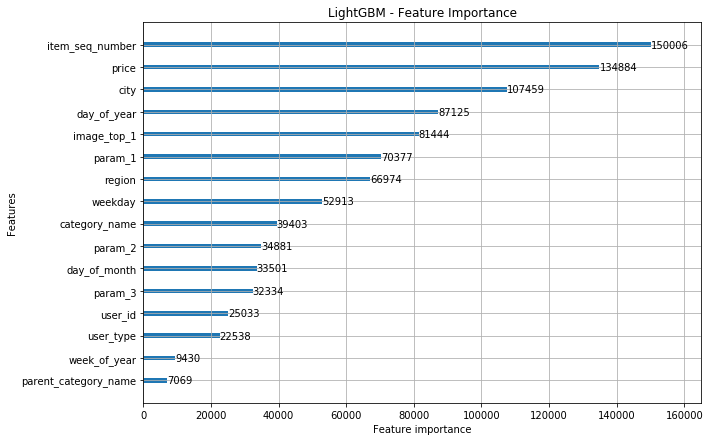

In [48]:
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");